Improving the neural network performance compared to sklearn's MLPRegressor

In [1]:
# general packages
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns    # this is only for the heatmap for the confusion matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# personal pipeline.py file
from pipeline import Pipeline

# data packages
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA                   # PCA isn't the only choice, will try RFE next
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor         # linear regressor that is robust to outliers
from sklearn.model_selection import GridSearchCV
#from sklearn.neural_network import MLPRegressor        # scored around 0.19 to 0.20 in my first try with it
from keras.models import Sequential                     # also scoring ~0.19 with PCA as the feature reduction method, try RFE
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


In [2]:
df_train = pd.read_csv(r'D:\Users\Liam\Desktop\VS code\Data Science\Kaggle Competitions\House Prices\train.csv')
df_test  = pd.read_csv(r'D:\Users\Liam\Desktop\VS code\Data Science\Kaggle Competitions\House Prices\test.csv')

df_train.head(3)
# lots of missing features and non-numerical ones.
# plenty of cleaning needed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# Cleaning

### Method:

- Encode all columns to numerical values
- Clean simple missing values (i.e. no Alley, Fence etc., NaN means none found, replace as new encoded value)
- Clean complex missing values (e.g. If no fireplaces, fireplace quality is not NaN, rather a new encoded value again)
- Fill missing LotFrontage values through linear regression (trained via relation with LotArea)
- Fill missing values that cross-reference eachother (similar to complex cleaning, but over larger range of features)
- Fill last remaining missing values via relation with their best correlated feature

In [3]:
training_set = Pipeline(df_train, verbose=False)
test_set = Pipeline(df_test, verbose=False)

# Encoding the columns into integer values

for column in training_set.dataframe.columns[training_set.dataframe.dtypes == np.object_]:
    training_set.encode(column)
    test_set.encode(column)

# Now necessary to asses the missing values in each df

nan_cols = []
for i in training_set.dataframe.columns:
    if training_set.dataframe[i].isnull().values.any():
        nan_cols.append(i)

print(training_set.dataframe.isna().sum().sum(), 'cases of NaN in the training set.')

# That's quite a lot for ~1500 rows, best way to deal with these?

6965 cases of NaN in the training set.


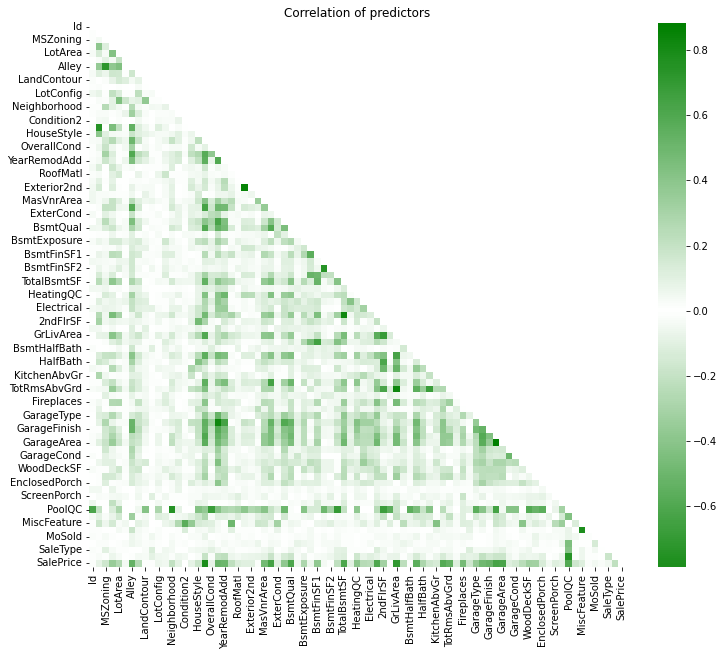

In [4]:
# seeing if there's obvious correlations between predictors, good for feature reduction
corr = training_set.dataframe.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap=LinearSegmentedColormap.from_list('gwg',["g", "w", "g"], N=256) , mask=mask, center=0)
plt.title("Correlation of predictors")
plt.show()

# A couple that do seem to have good relations, others that just show no relation
# definitely a good time to use PCA

In [5]:
corrs_view = corr['SalePrice']

if training_set.verbose:

    fig = plt.figure(figsize=(14,5))
    plt.title('Correlations against the sales price')
    plt.ylabel('Corr')
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

    plt.plot(corrs_view[0:-1], label='Correlation')
    plt.plot(np.abs(corrs_view[0:-1]), label='Absolute Correlation')
    plt.axhline(0, c='gray')
    plt.scatter(corr['SalePrice'][0:-1].argmax(),corr['SalePrice'][0:-1].max(),
                linewidth = 0.4, c='black', label='best feature')
    plt.legend()

In [6]:
# viewing only the correlation of these columns against the sales price, to see if removal is an awful idea

if training_set.verbose:

    fig = plt.figure(figsize=(14,5))
    plt.title('Absolute correlations of features against the sales price')
    plt.ylabel('Correlation strength')
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

    plt.plot(np.abs(corrs_view[0:-1]), label='All Columns')
    plt.scatter(corrs_view[nan_cols].index, np.abs(corrs_view[nan_cols]), c='black', label='Columns w/ NaN')
    plt.axhline(0.5, c='gray', linestyle='--')
    plt.legend()

    # some of the features are quite valuable, there are 3 with a correlation greater than 0.5 and another 3 over 0.4
    # it's certainly worth trying to keep the most valuable ones

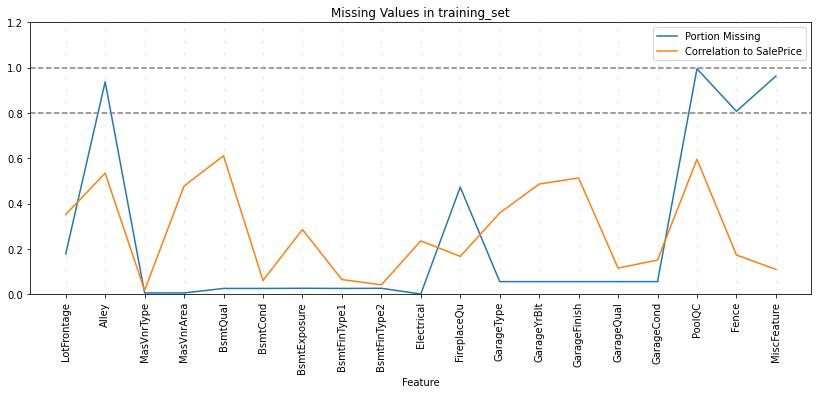

In [7]:
# observing the number of missing values in these columns, if there are loads, they might be worth dropping outright.
# lower correlation ones can be tuned out by RFE or PCA.

nans_in_col = []
nans_in_col_frac = []

for column in nan_cols:
    missing_sum = training_set.dataframe[column].isna().sum()
    nans_in_col.append(missing_sum)
    nans_in_col_frac.append(missing_sum/len(training_set.dataframe))
        
fig = plt.figure(figsize=(14,5))
plt.title('Missing Values in training_set')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)

plt.plot(nan_cols, nans_in_col_frac, label = 'Portion Missing')
plt.plot(nan_cols, np.abs(corrs_view[nan_cols]), label = 'Correlation to SalePrice')
plt.ylim(0,1.2)

plt.axhline(0.8, c='gray', linestyle='--')
plt.axhline(1, c='gray', linestyle='--')
plt.legend()

In [8]:
### Simple Cleaning:

# Where a feature's missing values are very likely to just be a missing label,
# e.g no alley as its own label, not NaN.

# This cleaning should be done sparingly, as it could well be removing valid missing values at the same time,
# these values were selected because they featured a very large portion of missing values (>0.8), making cleaning by
# inference for these features very difficult.

for column in ['Alley', 'Fence', 'MiscFeature']:
    training_set.fill_missing_simple(column)
    test_set.fill_missing_simple(column)

### Complex cleaning:

# An example:
# fireplace quality will be missing where the number of fireplaces is 0,
# if all other numbers of fireplaces have all their qualities, there are no true missing values, just mislabelled ones.
# Where this occurs, we can just bluntly replace all NaN values with a new encoding value without risk.

print(training_set.dataframe.FireplaceQu[training_set.dataframe.Fireplaces!=0].isna().sum(),
      test_set.dataframe.FireplaceQu[test_set.dataframe.Fireplaces!=0].isna().sum())
print('no true missing FireplaceQu values')

training_set.fill_missing_complex('FireplaceQu', 'Fireplaces')
test_set.fill_missing_complex('FireplaceQu', 'Fireplaces')

training_set.fill_missing_complex('PoolQC', 'PoolArea')
test_set.fill_missing_complex('PoolQC', 'PoolArea')


0 0
no true missing FireplaceQu values


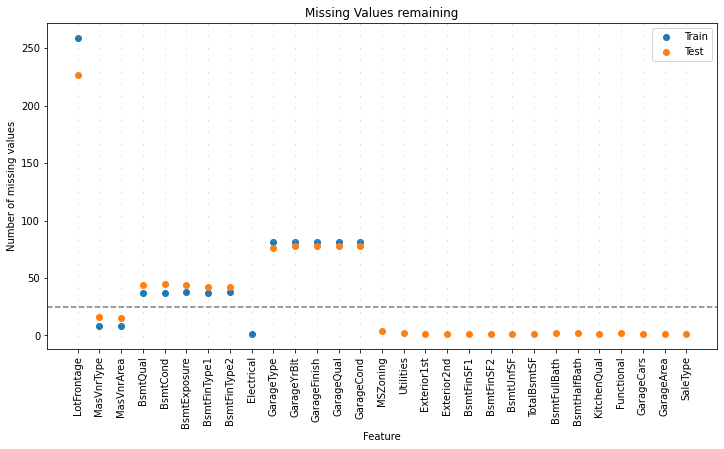

In [9]:
# now need to see what missing values exist in each set and where, whatever's left may well be worth dropping

def missing_val_cols(dataframe):

    '''
    Finds the columns with missing values and the number of values missing in said column.
    '''

    nan_cols_df = []
    nans_in_col_df = []

    for column in dataframe.columns[:-1]:
        if dataframe[column].isnull().values.any()==True:
            nan_cols_df.append(column)

    for column in nan_cols_df:
        nans_in_col_df.append(dataframe[column].isna().sum())

    return nan_cols_df, nans_in_col_df

def missing_val_graph():

    '''
    Plots the missing values for columns.
    
    Uses missing_val_cols function.
    '''
    
    nan_cols_tr, nans_in_col_tr = missing_val_cols(training_set.dataframe)
    nan_cols_te, nans_in_col_te = missing_val_cols(test_set.dataframe)
    
    fig = plt.figure(figsize=(12,6))
    plt.title('Missing Values remaining')
    plt.xlabel('Feature')
    plt.ylabel('Number of missing values')
    plt.xticks(rotation=90)
    plt.grid(axis = 'x', linestyle = (0, (3, 10, 1, 10)), linewidth = 0.5)
    plt.axhline(25, c='gray', linestyle='--')  
    plt.scatter(nan_cols_tr, nans_in_col_tr, label = 'Train')
    plt.scatter(nan_cols_te, nans_in_col_te, label = 'Test')
    plt.legend()
    plt.show()
    
nan_cols_tr, nans_in_col_tr = missing_val_cols(training_set.dataframe)
nan_cols_te, nans_in_col_te = missing_val_cols(test_set.dataframe)

missing_val_graph()

In [10]:
# Lot Frontage is missing a load of values, view the correlations closely to look at fixing this.

corr_lot = training_set.dataframe.corr()['LotFrontage']  # refresh and refine
corr_lot.drop(labels=['LotFrontage'], inplace=True)

if training_set.verbose:
    fig = plt.figure(figsize=(14, 5))
    plt.title('Correlations against the lot frontage')
    plt.ylabel('Corr')
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.grid(axis='x', linestyle=(0, (3, 10, 1, 10)), linewidth=0.5)

    plt.plot(corr_lot, label='Correlation')
    plt.plot(np.abs(corr_lot), label='Absolute Correlation')
    plt.axhline(0, c='gray')
    plt.scatter(corr_lot.argmax(), corr_lot.max(),
                linewidth=0.4, c='black', label='best feature')
    plt.legend()

print(training_set.dataframe.columns[1+corr_lot.argmax()], corr_lot[corr_lot.argmax()])

# Has some correlation with LotArea, 1stFlrSF (1st floor square footage) and BldgType.

1stFlrSF 0.45718100199465517


Total missing LotFrontage: 259
Total missing LotArea: 0


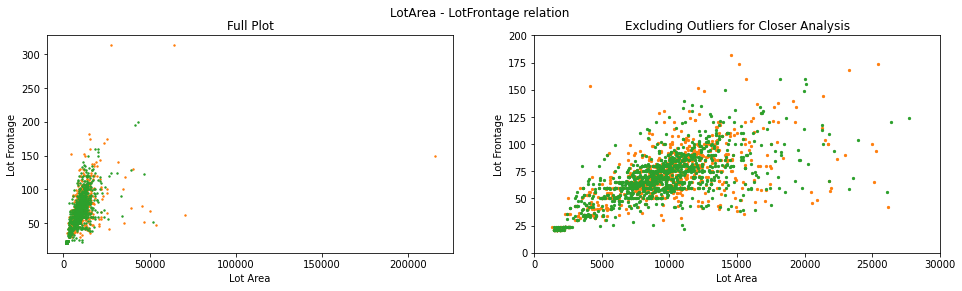

In [11]:
# Checking the LotArea relation, might be able to form some relation
print('Total missing LotFrontage:',training_set.dataframe.LotFrontage.isna().sum())
print('Total missing LotArea:',training_set.dataframe.LotArea.isna().sum())

# Definitely can't just look to exclude missing area and frontage combinations

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('LotArea - LotFrontage relation')

ax1.scatter(training_set.dataframe.LotArea, training_set.dataframe.LotFrontage, 
            c='C1', s=2, label='training_set')
ax1.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
            c='C2', s=2, label='test_set')
ax1.set_title('Full Plot')
ax1.set_xlabel('Lot Area')
ax1.set_ylabel('Lot Frontage')

ax2.scatter(training_set.dataframe.LotArea, training_set.dataframe.LotFrontage, 
            c='C1', s=5, label='training_set')
ax2.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
            c='C2', s=5, label='test_set')
ax2.set_title('Excluding Outliers for Closer Analysis')
ax2.set_xlabel('Lot Area')
ax2.set_ylabel('Lot Frontage')
ax2.set_xlim(0, 30000)
ax2.set_ylim(0,200)
plt.show()

# Primetime for a simple linear regression in both data sets

In [12]:
# Train the regressor on the present combinations of lot area/frontage and apply to the missing ones
# Must be completed on both the training and test sets, but it's probably best practice to only use the training set to train this
# regressor.

# Will also want to deal with the outliers (say, remove any LA>75000 and any LF>220) otherwise they'll hugely hinder the regressor
# - - - settled on using a more robust regressor for this.

a = training_set.dataframe.LotArea[training_set.dataframe.LotFrontage.notna()].to_numpy().reshape(-1,1)         # x value
b = training_set.dataframe.LotFrontage[training_set.dataframe.LotFrontage.notna()].to_numpy()                   # y value

regr = HuberRegressor().fit(a,b) # more robust than linear regressor for the large outliers

c = training_set.dataframe.LotArea[training_set.dataframe.LotFrontage.isna()].to_numpy().reshape(-1,1)          # x value for predictions on training set
d = regr.predict(c)                                                                                             # y value for predictions on training set
e = test_set.dataframe.LotArea[test_set.dataframe.LotFrontage.isna()].to_numpy().reshape(-1,1)                  # x value for predictions on test set
f = regr.predict(e)                                                                                             # y value for predictions on test set

In [13]:
# viewing the relations created

if training_set.verbose:
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(26, 4))
    fig.suptitle('LotArea - LotFrontage relation')

    ax0.scatter(training_set.dataframe.LotArea, training_set.dataframe.LotFrontage, 
                c='C1', s=2, label='training_set')
    ax0.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
                c='C2', s=2, label='test_set')
    ax0.plot(c,d, label='Regression line')
    ax0.set_title('Predicted')
    ax0.set_xlabel('Lot Area')
    ax0.set_ylabel('Lot Frontage')

    ax1.scatter(training_set.dataframe.LotArea, training_set.dataframe.LotFrontage, 
                c='C1', s=2, label='training_set')
    ax1.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
                c='C2', s=2, label='test_set')
    ax1.plot(c,d, label='Regression line')
    ax1.set_title('Predicted (zoomed)')
    ax1.set_xlabel('Lot Area')
    ax1.set_ylabel('Lot Frontage')
    ax1.set_xlim(0, 30000)
    ax1.set_ylim(0,200)

    ax2.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
                c='C1', s=2, label='test_set')
    ax2.scatter(e,f, c='C1', s=2, label='test_set predicted')
    ax2.set_title('Predicted and true training data - highlighted')
    ax2.set_xlabel('Lot Area')
    ax2.set_ylabel('Lot Frontage')

    ax3.scatter(test_set.dataframe.LotArea, test_set.dataframe.LotFrontage, 
                c='C1', s=2, label='test_set')
    ax3.scatter(e,f, c='C3', s=5, label='test_set predicted')
    ax3.set_title('Predicted and true training data - highlighted')
    ax3.set_xlabel('Lot Area')
    ax3.set_ylabel('Lot Frontage')
    plt.show()

In [14]:
# now to fill those NaNs with the predictive values:
training_set.dataframe.loc[training_set.dataframe.LotFrontage.isna(),'LotFrontage'] = d
test_set.dataframe.loc[test_set.dataframe.LotFrontage.isna(), 'LotFrontage'] = f

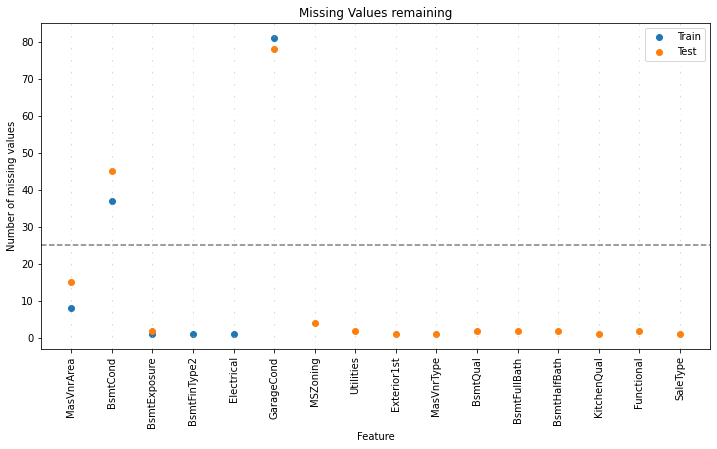

In [15]:
# There are lots of missing features that seem to relate, basement and garage sets especially, 
# maybe these can be cleaned as some sort of group.

# cross reference feature for the bsmt and garage sets,
# just check if they have 'GarageCond' or 'BsmtCond' given, otherwise they probably just don't have a garage or basement.

basement_list = ['BsmtQual','BsmtExposure','BsmtFinType1', 'BsmtFinType2','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']    # using 'BsmtCond'
garage_list = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCars','GarageArea']                                    # using 'GarageCond'
masonry_list = ['MasVnrType']                                                                                                       # using 'MasVnrArea'
exterior_list = ['Exterior2nd']                                                                                                     # using 'Exterior1st'

training_set.cross_checker('BsmtCond', basement_list)
test_set.cross_checker('BsmtCond', basement_list)

training_set.cross_checker('GarageCond', garage_list)
test_set.cross_checker('GarageCond', garage_list)

training_set.cross_checker('MasVnrArea', masonry_list)
test_set.cross_checker('MasVnrArea', masonry_list)

training_set.cross_checker('Exterior1st', exterior_list)
test_set.cross_checker('Exterior1st', exterior_list)

missing_val_graph()

In [16]:
# Now need to look at reducing those input features, BsmtCond and GarageCond.
# Let's see the correlations

if training_set.verbose:

    corr_bsmt = training_set.dataframe.corr()['BsmtCond']       # refresh and refine
    corr_bsmt.drop(labels=['BsmtCond'], inplace=True)           # stops self-reference
    corr_bsmt.drop(labels=basement_list, inplace=True)          # stops reference to something that relies on this

    corr_garage = training_set.dataframe.corr()['GarageCond']   # refresh and refine
    corr_garage.drop(labels=['GarageCond'], inplace=True)       # stops self-reference
    corr_garage.drop(labels=garage_list, inplace=True)          # stops reference to something that relies on this

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(26, 4))
    fig.suptitle('Feature Targets')
    
    ax0.set_title('Correlations against the BsmtCond')
    ax0.set_ylabel('Corr')
    ax0.set_xlabel('Feature')
    ax0.tick_params(labelrotation=90)
    ax0.grid(axis='x', linestyle=(0, (3, 10, 1, 10)), linewidth=0.5)
    ax0.plot(np.abs(corr_bsmt), label='Absolute Correlation')
    ax0.axhline(0, c='gray')
    ax0.scatter(corr_bsmt.argmax(), corr_bsmt.max(),
                linewidth=0.4, c='black', label='best feature')

    ax1.set_title('Correlations against GarageCond')
    ax1.set_ylabel('Corr')
    ax1.set_xlabel('Feature')
    ax1.tick_params(labelrotation=90)
    ax1.grid(axis='x', linestyle=(0, (3, 10, 1, 10)), linewidth=0.5)

    ax1.plot(np.abs(corr_garage), label='Absolute Correlation')
    ax1.axhline(0, c='gray')
    ax1.scatter(corr_garage.argmax(), corr_garage.max(),
                linewidth=0.4, c='black', label='best feature')
    plt.legend()
    ax0.set_ylim(0,0.3)
    ax1.set_ylim(0,0.3)

# BsmtCond has no good relation, but GarageCond has a correlation of ~0.45 with GarageQual and 0.275 with YearBuilt
# Difficult to decide what to do, will just push for a more complex method with the rest of the missing values.

In [17]:
# to remove the NaN's again, I'll look to take the average from the most correlated features,
# using the original correlation, NOT a new one. However, must be vigilant of using columns
# that also have missing values

corr_new = training_set.dataframe.corr()
corr_new.drop('SalePrice',   inplace=True)
corr_new.drop('SalePrice',   axis=1, inplace=True)

def most_correlated(feature_in, feat_no):
    '''
    Provides a selected number of most correlated features 
    and their absolute values. Useful for selecting feat2.

    Relies on the training set, as to stop bleed from the test set.
    '''
    corr_values = (np.abs(corr_new[feature_in])).sort_values(ascending=False)[1:feat_no+1]
    
    return(corr_values)

def feature_correlations(columns):
    '''
    Finds the most correlated feature for a given feature.

    Uses most_correlated().
    '''
    feature_corr = []

    for feat1 in columns:
        feature_correlations = most_correlated(feat1,3)
        corr_feat_name = feature_correlations.index[0]
        #corr_feat_val  = feature_correlations[0]
        
        feature_corr.append((feat1, corr_feat_name))#, corr_feat_val))

    return feature_corr
    
# To use the filler_from_corr function, must first find all the next most related feature.
# This has to be done seperately for test and train, as they have different missing values.

# regenerate the columns to be looped through
nan_cols_tr, nans_in_col_tr = missing_val_cols(training_set.dataframe)
nan_cols_te, nans_in_col_te = missing_val_cols(test_set.dataframe)

train_feature_corrs = feature_correlations(nan_cols_tr)
test_feature_corrs = feature_correlations(nan_cols_te)

In [18]:
def filler_from_corr(dataframe, feat1, feat2, verbose=False):
    '''
    Cleans the missing values in a column (feat1) for a given dataframe,
    taking the expected value for that feature using the average/median of 
    the most correlated feature (feat2).
    '''
    
    # Given dataframe so it can be performed on both train and test as wanted, 
    # but not for looping.
    # Given most correlated feature to remove the need for repeated calculation.
    
    if dataframe[feat1].isna().sum() == 0:
        print(feat1,'No values to replace, exiting.')
        return
    
    if verbose==True:        # mostly for tests
        print(dataframe[feat1].isna().sum(), 'missing vals in', feat1, 'going in.')
        
    feat2of1 = dataframe.loc[dataframe[feat1].isna(),feat2]         # all the values for feat2 of the rows that have nans in feat1
    feat2of1.dropna(inplace=True)                                  # don't want them working into the values if they're common
    
    feat2_vals = list( dict.fromkeys(feat2of1.sort_values(ascending=True))) # refining to non-repeated values, to be worked through
    # feat2_vals describes all the values of feat2 that map to a missing feat1 value, find the feat1 average of these and plug it in
    
    df_feat1_nans = dataframe[pd.isna(dataframe[feat1])]                    # the rows that want replacing
    df_train_good = training_set.dataframe.dropna(subset = [feat1])[[feat1, feat2]]       # for calculating the average with regards to the training set
    df_feat1_good = dataframe.dropna(subset = [feat1])                      # must drop rows with the nans for recombination
    
    if len(df_train_good)==0:
        # in the event that there are no suitable values to be generated from feat2 related rows,
        # just return and change to the next most relevant feat2
        print('No viable replacements, try a different feat2')
        return
    
    all_clean_feat1 = []
    
    for i in feat2_vals:
        
        mean_val = (df_train_good[df_train_good[feat2]==i])[feat1].mode().mean()
        
        if mean_val != mean_val:
            if verbose==True:        # mostly for tests
                print(i, 'Not a good relation, running large-scale mean.')
                
            mean_val = df_train_good[feat1].mode().mean()
            feat1_mean = int(mean_val)
            
        else:
            feat1_mean = int(mean_val)
        
        # finds the most common type of the first feature for each of the second feature's values
        # (cannot use mean due to discrete labels >{0,1})
        # the output is also rounded to an int just for conformity.

        cleaned_feat1 = df_feat1_nans[df_feat1_nans[feat2]==i][feat1].fillna(feat1_mean)
        all_clean_feat1.append(cleaned_feat1)      
    
    dataframe[feat1] = pd.concat([df_feat1_good[feat1], pd.concat(all_clean_feat1)])
    
    if verbose==True:        # mostly for tests - also relevant to complete cleaning
        print(dataframe[feat1].isna().sum(), 'missing vals in', feat1, 'coming out.')
        
    return

In [19]:
for i in range(len(train_feature_corrs)):
    filler_from_corr(training_set.dataframe, train_feature_corrs[i][0], train_feature_corrs[i][1], verbose=False)

for i in range(len(test_feature_corrs)):
    filler_from_corr(test_set.dataframe, test_feature_corrs[i][0], test_feature_corrs[i][1], verbose=False)

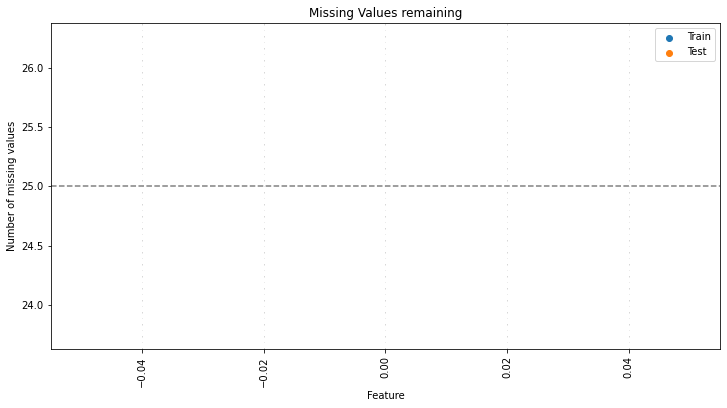

In [20]:
missing_val_graph()

# It's empty

# Modeling

## All the missing values are replaced, onto the model!

The previous model was a basic linear regression (after PCA) with the data having undergone slightly less cleaning than this. I could move on to a random forest regressor after the same system, but I'm not sure that will bump it much.

I'd like to look at introducing a neural network and gradient descent to improve the system dramatically. This will still require some dimensionality reduction.

- log of the training y values
- rescale all values
- train keras neural network model
- gridsearchcv for best hyperparameters for the model
- predict test y values
- rescale out, then exponent these
- sumbit to Kaggle.

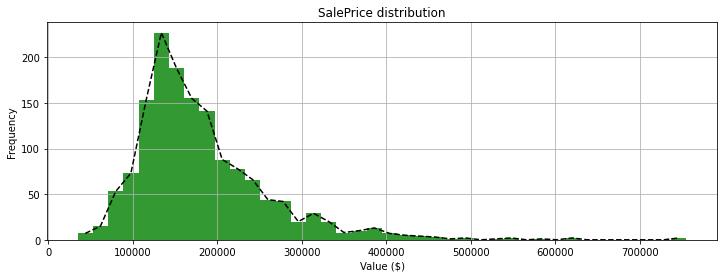

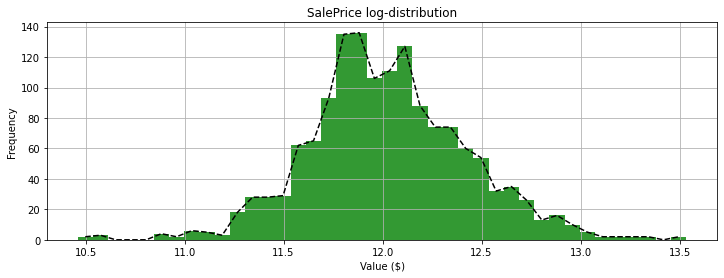

In [21]:
# not very experienced with histograms,

def histo_func(X_list, bins_no, title='SalePrice distribution'):
    fig = plt.figure(figsize=(12,4))
    n, bins, patches = plt.hist(X_list, bins_no, facecolor='g', density=False, alpha=0.8)
    bin_center = bins[:-1] + np.diff(bins) / 2

    plt.xlabel('Value ($)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    plt.plot(bin_center,n,'--',c='black')
    plt.show()

histo_func(training_set.dataframe['SalePrice'], 40)
histo_func(np.log1p(training_set.dataframe['SalePrice']), 40, title='SalePrice log-distribution')

# the initial feature is skewed very heavily, but the log is not, 
# take these values to improve the capacity of the sklearn algorithms, must reverse this at the end!

In [22]:
X = training_set.dataframe.drop(['SalePrice'], axis=1)
y = training_set.dataframe[['SalePrice']]
y = np.log1p(y)

# should scale data before PCA
#st_scaler = StandardScaler().fit(X)        # fit to training set and apply to both
st_scaler = MinMaxScaler().fit(X)
X = st_scaler.transform(X)
X_df_test = st_scaler.transform(df_test)   # repeat the rescaling to the X values for the test set

mm_scaler = MinMaxScaler().fit(y)          # will want to view the y out so will need inversion later
#mm_scaler = StandardScaler().fit(y)
y = mm_scaler.transform(y)                 # mm_scaler.inverse_transform(y)

In [23]:
# proof of inversion back to the original y values
if training_set.verbose:
    histo_func(y, 40)
    histo_func(np.expm1(mm_scaler.inverse_transform(y)), 40)

# Replace PCA with some sort other feature engineering

- forward/back elimination
- rfe 

In [24]:
# worth generating a smaller test-train split to check the quality of the model against itself before entering into the blind test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

pca = PCA(.995)        # maintaining 95% of the variance of the original features, could easily drop to ~80% without issue

pca.fit(X_train)
principalComp_tr = pca.transform(X_train)
principalComp_te = pca.transform(X_test)

X_train_pca = pd.DataFrame(data = principalComp_tr)
X_test_pca = pd.DataFrame(data = principalComp_te)

print(training_set.dataframe.shape[1], 'features drops to', X_train_pca.shape[1])

81 features drops to 67


In [25]:
# create ANN model

def create_NN(neurons_1=10, neurons_2=10):
	# create model
    model = Sequential()

    model.add(Dense(units=neurons_1,
        input_dim=X_train_pca.shape[1], 
        kernel_initializer='normal', 
        activation='relu'))
    
    model.add(Dense(units=neurons_2, 
        kernel_initializer='normal', 
        activation='tanh'))
    
    model.add(Dense(units=1, kernel_initializer='normal'))
	
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return model

regr = KerasRegressor(build_fn=create_NN, verbose=0)
regr.fit(X_train_pca, y_train ,batch_size = 10, epochs = 10, verbose=0)

In [26]:
# This will take a little while, so after I've gotten an output, I'll just resort to putting those in directly
# so I don't have to run it again!

# Took 496.7s
# Best: -0.002525 using {'batch_size': 10, 'epochs': 10, 'neurons_1': 25, 'neurons_2': 5}

# refined search:
# Took 319.6s
# Best: -0.002443 using {'batch_size': 10, 'epochs': 10, 'neurons_1': 20, 'neurons_2': 5}

if False:
    # define the grid search parameters
    batch_size = [5, 10, 20, 40]
    epochs = [5, 10, 50]
    neurons = [5, 10, 20, 30, 40]
    param_grid = dict(batch_size=batch_size, epochs=epochs, neurons_1=neurons, neurons_2=neurons)

    grid = GridSearchCV(estimator=regr, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train_pca, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [27]:
# fitting to these new best parameters:
regr = KerasRegressor(build_fn=create_NN, neurons_1=20, neurons_2=5, verbose=0)
regr.fit(X_train_pca, y_train ,batch_size = 10, epochs = 10, verbose=0)

In [28]:
# competition will use RMSE to judge the model, so best to use that here too
y_train_pred = regr.predict(X_train_pca)
y_test_pred  = regr.predict(X_test_pca)

print(mean_squared_error(y_train, y_train_pred, squared=False))
print(mean_squared_error(y_test, y_test_pred, squared=False))

0.03942058543294398
0.03920363661074945


In [29]:
test_ID = df_test['Id']

# X_df_test was rescaled earlier

pca_test_set = pca.transform(X_df_test)
X_test_pca_true = pd.DataFrame(data = pca_test_set)
y_test_pred = pd.DataFrame(regr.predict(X_test_pca_true)).values   # forces the prediction into the right array shape

In [30]:
if training_set.verbose:
    histo_func(mm_scaler.inverse_transform(y), 40, title='SalePrice log-distribution')
    histo_func(mm_scaler.inverse_transform(y_test_pred), 40, title='Predicted SalePrice log-distribution')  

In [31]:
if training_set.verbose:
    histo_func(np.expm1(mm_scaler.inverse_transform(y)), 40)
    histo_func(np.expm1(mm_scaler.inverse_transform(y_test_pred)), 40, title='Predicted SalePrice distribution')

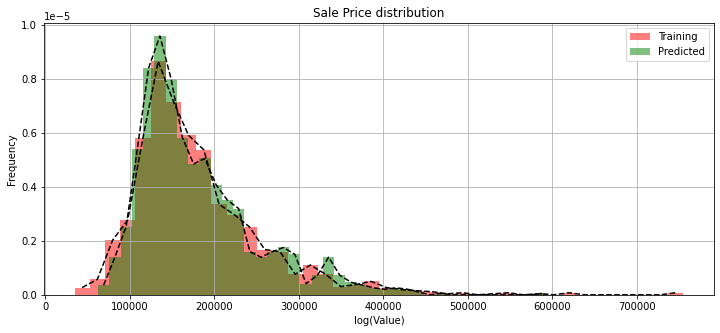

In [32]:
# must convert the y values back! (forgot this and got a RMSE value of 10.2, whoops!)

y_out = np.expm1(mm_scaler.inverse_transform(y_test_pred))


fig = plt.figure(figsize=(12,5))

n, bins, patches = plt.hist(df_train[['SalePrice']], 40, facecolor='r', density=True, alpha=0.5, label='Training')
bin_center1 = bins[:-1] + np.diff(bins) / 2
plt.plot(bin_center1,n,'--',c='black')

n, bins, patches = plt.hist(y_out, 40, facecolor='g', density=True, alpha=0.5, label='Predicted')
bin_center = bins[:-1] + np.diff(bins) / 2
plt.plot(bin_center,n,'--',c='black')

plt.xlabel('log(Value)')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
d = {'Id':test_ID, 'SalePrice':y_out.flatten()}

#gender_sub_df = pd.DataFrame(data=d)
gender_sub_df = pd.DataFrame.from_dict(data=d)
gender_sub_df.to_csv('HP_neural.csv',index=False)